In [46]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

In [4]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# 1. Data Preparation

In [5]:
df = pd.read_csv(r'..\..\data\preprocessed_dataset.csv')
df.head(5)

,date,cpi_rate,xau_usd_rate_log_return,pe_ratio_log_return,fpt_stock_price,gdp_value,fpt_stock_price_log_return,cpi_rate_log_return,usd_vnd_rate_log_return,fpt_stock_volume_log_return
0,2020-01-01,0.0643,0.999818,-0.020095,21.39,3.466157e+11,-0.055765,0.01877,0.067868,-0.003521
1,2020-01-02,0.0643,0.999818,-0.020095,21.39,3.466157e+11,-0.055765,0.01877,0.067868,-0.003521
2,2020-01-03,0.0643,1.626549,-0.020095,21.03,3.466157e+11,-1.040504,0.01877,-0.081355,1.709207
3,2020-01-06,0.0643,2.133883,-0.020095,20.81,3.466157e+11,-0.665883,0.01877,0.040724,-1.308273
4,2020-01-07,0.0643,-0.470972,-0.020095,21.21,3.466157e+11,1.048811,0.01877,-0.027099,-0.553839


In [6]:
scaler_fpt = StandardScaler()
scaler_gdp = StandardScaler()

def process_data(dataset, is_train=True):
    df_out = dataset.copy()
    
    col_fpt = ['fpt_stock_price']
    col_gdp = ['gdp_value']

    if is_train:
        df_out[col_fpt] = scaler_fpt.fit_transform(df_out[col_fpt])
        df_out[col_gdp] = scaler_gdp.fit_transform(df_out[col_gdp])
    else:
        df_out[col_fpt] = scaler_fpt.transform(df_out[col_fpt])
        df_out[col_gdp] = scaler_gdp.transform(df_out[col_gdp])
        
    return df_out

## 1.1. Separate Dataset

In [7]:
_train, _test = train_test_split(df, test_size=0.15, shuffle=False)

train = process_data(_train, is_train=True)
test = process_data(_test, is_train=False)

In [45]:
test

,date,cpi_rate,xau_usd_rate_log_return,pe_ratio_log_return,fpt_stock_price,gdp_value,fpt_stock_price_log_return,cpi_rate_log_return,usd_vnd_rate_log_return,fpt_stock_volume_log_return
1299,2024-11-19,0.0289,1.031349,-0.020095,2.187822,1.513602,-1.816531,0.01877,-0.054225,1.388691
1300,2024-11-20,0.0289,0.633560,-0.020095,2.265283,1.513602,1.008117,0.01877,0.131270,0.207916
1301,2024-11-21,0.0289,0.742293,-0.020095,2.284460,1.513602,0.204638,0.01877,0.168296,-2.034223
1302,2024-11-22,0.0289,1.642826,-0.020095,2.313414,1.513602,0.335191,0.01877,-0.091306,-0.181840
1303,2024-11-25,0.0289,0.297915,-0.020095,2.313414,1.513602,-0.055765,0.01877,-0.239665,-0.945066
...,...,...,...,...,...,...,...,...,...,...
1524,2025-09-24,0.0324,-0.434974,-0.020095,1.743740,2.715680,0.825509,0.01877,-0.149365,-1.874443
1525,2025-09-25,0.0324,-0.634456,-0.020095,1.687337,2.715680,-0.937040,0.01877,-0.149379,0.308926
1526,2025-09-26,0.0324,0.623868,-0.020095,1.668536,2.715680,-0.352523,0.01877,-0.185086,-0.139339
1527,2025-09-29,0.0324,1.502127,-0.020095,1.593332,2.715680,-1.258215,0.01877,0.207470,0.525929


In [8]:
TARGET_COL = 'fpt_stock_price_log_return'
REMOVED =  'fpt_stock_price'

# --- Tách tập TRAIN ---
X_train = train.drop(columns=[TARGET_COL, 'date', REMOVED])
y_train = train[TARGET_COL]

# --- Tách tập TEST ---
X_test = test.drop(columns=[TARGET_COL, 'date', REMOVED])
y_test = test[TARGET_COL]

print("Đã tách dữ liệu thành X_train, y_train, X_test, y_test thành công!")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Đã tách dữ liệu thành X_train, y_train, X_test, y_test thành công!
X_train shape: (1299, 7)
y_train shape: (1299,)


## 1.2. Tensor Import

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X_data: pd.DataFrame, Y_data: pd.Series):
        X_numpy = X_data.values
        Y_numpy = Y_data.values
        if Y_numpy.ndim == 1:
            Y_numpy = Y_numpy.reshape(-1, 1)
        self.X_tensor = torch.tensor(X_numpy, dtype=torch.float32).unsqueeze(1)
        self.Y_tensor = torch.tensor(Y_numpy, dtype=torch.float32)
        
    def __len__(self):
        """Trả về tổng số samples."""
        return len(self.X_tensor)
    
    def __getitem__(self, idx):
        """Trả về cặp (feature, target) cho index."""
        return self.X_tensor[idx], self.Y_tensor[idx]

In [10]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
BATCH_SIZE = 64 

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False 
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

print("-" * 50)
print("✅ Đã tạo DataLoader thành công.")
print(f"Tổng số batch cho Train: {len(train_loader)}")
print(f"Tổng số batch cho Test: {len(test_loader)}")

--------------------------------------------------
✅ Đã tạo DataLoader thành công.
Tổng số batch cho Train: 21
Tổng số batch cho Test: 4


## 1.3. Model 

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[:, -1, :])
        
        return out

# 2. Training

## 2.1. Configuration

In [29]:
INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

In [30]:
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Đã định nghĩa và khởi tạo mô hình LSTM ({NUM_LAYERS} lớp) trên {device}.")
print("\n--- Cấu trúc Mô hình ---")
print(model)

✅ Đã định nghĩa và khởi tạo mô hình LSTM (2 lớp) trên cuda.

--- Cấu trúc Mô hình ---
LSTMModel(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


## 2.2. Training

In [31]:
import torch.nn as nn
import torch.optim as optim
import torch

loss_fn = nn.MSELoss() 
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) 

In [32]:
def train_model(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device, 
                      patience=100): 
    """
    Huấn luyện mô hình với Early Stopping và Model Checkpointing (chỉ dựa trên Test Loss).
    
    Args:
        patience (int): Số epochs tối đa Test Loss không được cải thiện.
    """
    
    # Khởi tạo giá trị tốt nhất và bộ đếm Early Stopping
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    
    model.train() 
    for epoch in range(num_epochs):
        train_loss = 0.0
        
        # --- TRAINING LOOP (Forward -> Backward -> Optimize) ---
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
            
        # --- VALIDATION LOOP (Checkpointing và Early Stopping) ---
        model.eval() 
        test_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        
        # Tính Average Loss
        train_loss /= len(train_loader.dataset)
        test_loss /= len(test_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
        
        # 1. Kiểm tra Checkpointing (Lưu mô hình tốt nhất)
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            # Lưu trạng thái mô hình tốt nhất (trọng số)
            best_model_state = model.state_dict() 
            print(f"   [Checkpoint] Test Loss giảm ({best_loss:.6f}). Lưu mô hình.")
        else:
            epochs_no_improve += 1
            
        # 2. Kiểm tra Early Stopping
        if epochs_no_improve >= patience:
            print(f"🛑 STOPPING: Early Stop kích hoạt. Test Loss không cải thiện sau {patience} epochs.")
            break
            
        model.train() # Quay lại chế độ train

    # Tải lại mô hình tốt nhất đã lưu trước khi kết thúc
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("✅ Tải lại trạng thái mô hình tốt nhất.")
        
    return model

In [33]:
EPOCHS = 500
train_model(model, train_loader, test_loader, loss_fn, optimizer, EPOCHS, device) 

print("✅ Đã viết xong hàm train_model. Bước tiếp theo là gọi hàm này để bắt đầu huấn luyện.")

Epoch [1/500], Train Loss: 0.979497, Test Loss: 1.154628
   [Checkpoint] Test Loss giảm (1.154628). Lưu mô hình.
Epoch [2/500], Train Loss: 0.973844, Test Loss: 1.143809
   [Checkpoint] Test Loss giảm (1.143809). Lưu mô hình.
Epoch [3/500], Train Loss: 0.971754, Test Loss: 1.139557
   [Checkpoint] Test Loss giảm (1.139557). Lưu mô hình.
Epoch [4/500], Train Loss: 0.970076, Test Loss: 1.137848
   [Checkpoint] Test Loss giảm (1.137848). Lưu mô hình.
Epoch [5/500], Train Loss: 0.968245, Test Loss: 1.136667
   [Checkpoint] Test Loss giảm (1.136667). Lưu mô hình.
Epoch [6/500], Train Loss: 0.966368, Test Loss: 1.135855
   [Checkpoint] Test Loss giảm (1.135855). Lưu mô hình.
Epoch [7/500], Train Loss: 0.964614, Test Loss: 1.135833
   [Checkpoint] Test Loss giảm (1.135833). Lưu mô hình.
Epoch [8/500], Train Loss: 0.963087, Test Loss: 1.136685
Epoch [9/500], Train Loss: 0.961773, Test Loss: 1.138132
Epoch [10/500], Train Loss: 0.960590, Test Loss: 1.139916
Epoch [11/500], Train Loss: 0.959461,

# 3. Predicting

In [47]:
def predict(model, loader, device):
    """
    Dự đoán, trả về Log Returns đã chuẩn hóa (Scaled), và tính R-squared.
    
    Args:
        model (torch.nn.Module): Mô hình đã được huấn luyện (LSTM).
        loader (torch.utils.data.DataLoader): DataLoader chứa dữ liệu Test.
        device (str): Thiết bị chạy mô hình ('cuda' hoặc 'cpu').
        
    Returns:
        y_pred_scaled (np.ndarray): Predicted Log Returns (Scaled).
        y_test_scaled (np.ndarray): Actual Log Returns (Scaled).
        time_index (np.ndarray): Index tuần tự.
        r2 (float): Hệ số xác định R-squared.
    """
    model.eval() 
    
    predictions = []
    actuals = []
    
    # 1. Chạy Inference (Dự đoán)
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model(X_batch)

            predictions.append(y_pred.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())

    # 2. Ghép các lô (batches) lại
    y_pred_scaled = np.concatenate(predictions, axis=0)
    y_test_scaled = np.concatenate(actuals, axis=0)

    # Đảm bảo dữ liệu có hình dạng phù hợp cho r2_score (thường là (N,) hoặc (N, 1))
    # Reshape về 1D nếu cần
    y_pred_flat = y_pred_scaled.flatten()
    y_test_flat = y_test_scaled.flatten()
    
    # 3. Tính R-squared
    r2 = r2_score(y_test_flat, y_pred_flat)
    
    time_index = np.arange(len(y_pred_scaled))
    
    print(f"\n✅ Dự đoán Log Returns hoàn tất.")
    print(f"📈 Hệ số R-squared trên tập Test (Scaled Data): {r2:.4f}")

    return y_pred_scaled, y_test_scaled, time_index, r2


In [50]:
y_predict, y_test, time, r2 = predict(
    model = model,
    loader = test_loader,
    device = 'cuda'
)


✅ Dự đoán Log Returns hoàn tất.
📈 Hệ số R-squared trên tập Test (Scaled Data): -0.5663


# 4. Visualize

R^2 : -0.5663491487503052


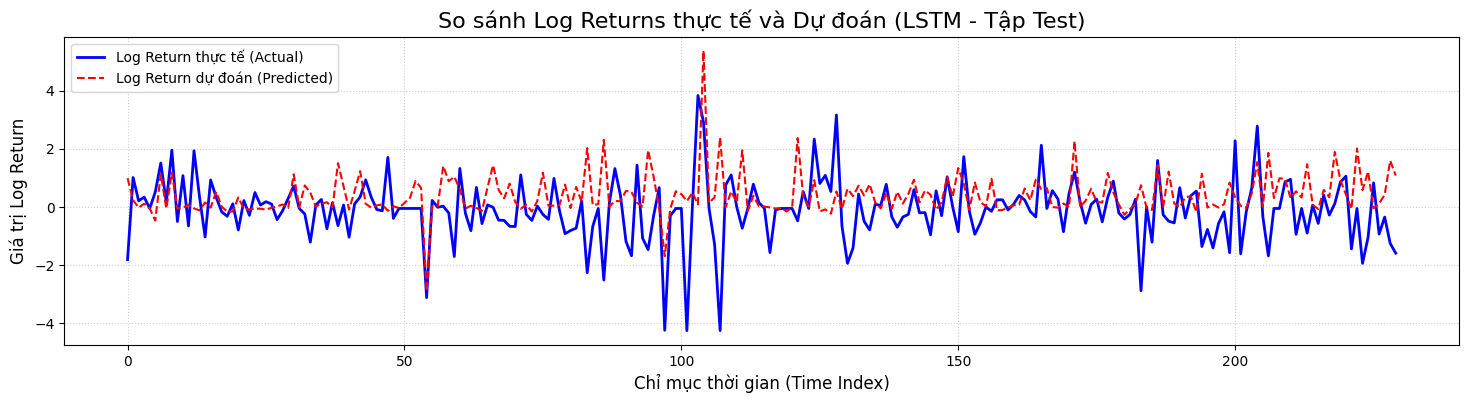

In [52]:
print(f'R^2 : {r2}')
plt.figure(figsize=(18, 4))

# Đường Log Return thực tế (Actual)
plt.plot(time, y_test.flatten(), 
         label='Log Return thực tế (Actual)', color='blue', linewidth=2)

# Đường Log Return dự đoán (Predicted)
plt.plot(time, y_predict.flatten(), 
         label='Log Return dự đoán (Predicted)', color='red', linestyle='--', linewidth=1.5)

# Thêm chi tiết biểu đồ
plt.title('So sánh Log Returns thực tế và Dự đoán (LSTM - Tập Test)', fontsize=16)
plt.xlabel('Chỉ mục thời gian (Time Index)', fontsize=12) 
plt.ylabel('Giá trị Log Return', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.show()